# How to perform population analysis with GWKokab?

If you have data from gravitational wave events or you have synthetic data generated using GWKokab then you can use this notebook to perform population analysis. To demonstrate the capabilities of GWKokab, we will use the synthetic data generated in the [Synthetic Data Generation with GWKokab][synthetic_data] tutorial. 


The fake posteriors are generated from [`PowerlawPrimaryMassRatio`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/index.html#gwkokab.models.PowerlawPrimaryMassRatio), see eq (B2) and eq (B3) of [Population of Merging Compact Binaries Inferred Using Gravitational Waves through GWTC-3](https://link.aps.org/doi/10.1103/PhysRevX.13.011048), for the primary and secondary mass of the binary system, and Truncated Normal distribution for the eccentricity of the orbit. The models are defined as follows:

$$
    p(m_1,q\mid\alpha,\beta,m_{\text{min}},m_{\text{max}})\propto
    m_1^{-\alpha}q^{\beta} \qquad \mathcal{N}_{[a,b]}(\varepsilon\mid\mu,\sigma^2)\propto\exp\left(-\frac{1}{2}\left(\frac{\varepsilon-\mu}{\sigma}\right)^2\right)\mathbb{1}_{[a,b]}(\varepsilon)
$$


## Environment Variables

GWKokab at its core used JAX for fast computation. To setup the behavior of JAX based on the accelerator you are using, you have to set the environment variables. Here are the environment variables that you can set:

[synthetic_data]: https://gwkokab.readthedocs.io/en/latest/examples/synthetic_data.html

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import os


env_vars = {
    "CUDA_VISIBLE_DEVICES": "0",
    "JAX_COMPILATION_CACHE_DIR": "jax_cache",
    "JAX_ENABLE_X64": "1",
    "JAX_PLATFORM_NAME": "cpu",
    "NPROC": "16",
    "XLA_FLAGS": "--xla_cpu_multi_thread_eigen=false",
    "XLA_PYTHON_CLIENT_ALLOCATOR": "platform",
}

for var, value in env_vars.items():
    os.environ[var] = value

## Importing libraries

Importing the required libraries for the code. 

In [3]:
from glob import glob

import numpy as np
import numpyro
from jax import numpy as jnp, random as jrd
from jaxtyping import ArrayLike
from numpyro import distributions as dist

from gwkokab.inference import Bake, poisson_likelihood
from gwkokab.models import PowerlawPrimaryMassRatio
from gwkokab.models.transformations import (
    PrimaryMassAndMassRatioToComponentMassesTransform,
)
from gwkokab.models.utils import JointDistribution, ScaledMixture
from gwkokab.parameters import ECCENTRICITY, PRIMARY_MASS_SOURCE, SECONDARY_MASS_SOURCE
from gwkokab.poisson_mean import PoissonMean
from gwkokab.vts import NeuralNetVolumeTimeSensitivity
from kokab.utils.common import get_posterior_data
from kokab.utils.flowMC_helper import flowMChandler

/opt/homebrew/anaconda3/envs/gwkenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0000 00:00:1748620148.237001 2885459 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1748620148.250521 2885459 service.cc:145] XLA service 0x13840ee30 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748620148.250533 2885459 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1748620148.251781 2885459 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1748620148.251793 2885459 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



/opt/homebrew/anaconda3/envs/gwkenv/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
2025-05-30 11:49:10.425 | DEBUG    | Setting LogLevel to TRACE
2025-05-30 11:49:10.426 | INFO     | ============================================================
2025-05-30 11:49:10.426 | INFO     | GWKokab INFO
2025-05-30 11:49:10.426 | INFO     | ============================================================
2025-05-30 11:49:10.4

In [4]:
numpyro.enable_validation()

By enabling validation of NumPyro distributions in the statement `numpyro.enable_validation()` we can ensure that the values that are outside the support of the distribution return `0.0` probability.

## Parameters

Our model is for Primary Mass $m_1$, Secondary Mass $m_2$, and Eccentricity $\varepsilon$ of the binary system. `parameters` contains their names that are recognized by GWKokab. It is handy to define them in the start and reuse them later in the code

In [5]:
parameters = [PRIMARY_MASS_SOURCE, SECONDARY_MASS_SOURCE, ECCENTRICITY]
parameters

[Parameter(name=mass_1_source, prior=Uniform(low=0.5, high=300.0)),
 Parameter(name=mass_2_source, prior=Uniform(low=0.5, high=300.0)),
 Parameter(name=eccentricity, prior=Uniform(low=0.0, high=1.0))]

## Model

Model definition is an integral part of GWKokab. A properly defined model is essential for correct inference. Each model is a probability distribution which is a subclass of [`numpyro.distributions.Distribution`](https://num.pyro.ai/en/stable/distributions.html#distribution).  We can also combine independent distributions to create a more complex model using [`gwkokab.model.utils.JointDistribution`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/utils/index.html#gwkokab.models.utils.JointDistribution). GWKokab is built for the inference of multi source population, which means each source would have its own model as well as their own rate. We have to scale each subpopulation model by its rate and combine them to create the final model. This is a standard approach to build and combine any model in GWKokab and the final model is of type [`gwkokab.models.utils.ScaledMixture`][ScaledMixture].

For this tutorial we have the mass model defined as,

$$
     p(m_1,q\mid\alpha,\beta,m_{\text{min}},m_{\text{max}})\propto
    m_1^{-\alpha}q^{\beta}
$$

and our eccentricity model is defined as,

$$
    \mathcal{N}_{[a,b]}(\varepsilon\mid\mu,\sigma^2)\propto\exp\left(-\frac{1}{2}\left(\frac{\varepsilon-\mu}{\sigma}\right)^2\right)\mathbb{1}_{[a,b]}(\varepsilon)
$$

We will write a `model_builder` function that will take the parameters of the model and return a [`ScaledMixture`][ScaledMixture] object.

[ScaledMixture]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/utils/index.html#gwkokab.models.utils.ScaledMixture

In [6]:
def model_builder(
    log_rate: ArrayLike,
    alpha: ArrayLike,
    beta: ArrayLike,
    mmax: ArrayLike,
    mmin: ArrayLike,
    loc: ArrayLike,
    scale: ArrayLike,
) -> ScaledMixture:
    """Scaled Joint Distribution of Primary Mass, Secondary Mass and Eccentricity.

    Parameters
    ----------
    log_rate : ArrayLike
        Merger rate of the population
    alpha : ArrayLike
        powerlaw index for the primary mass
    beta : ArrayLike
        powerlaw index for the mass ratio
    mmax : ArrayLike
        Maximum mass
    mmin : ArrayLike
        Minimum mass
    loc : ArrayLike
        mean of the gaussian distribution of eccentricity
    scale : ArrayLike
        standard deviation of the gaussian distribution of eccentricity

    Returns
    -------
    ScaledMixture
        A mixture of distributions for the primary mass, secondary mass and eccentricity
    """
    mass_model = dist.TransformedDistribution(
        PowerlawPrimaryMassRatio(
            alpha=alpha, beta=beta, mmax=mmax, mmin=mmin, validate_args=True
        ),
        PrimaryMassAndMassRatioToComponentMassesTransform(),
        validate_args=True,
    )
    eccentricity_model = dist.TruncatedNormal(
        low=0.0, high=1.0, loc=loc, scale=scale, validate_args=True
    )
    component_distributions = JointDistribution(
        mass_model, eccentricity_model, validate_args=True
    )
    return ScaledMixture(
        log_scales=jnp.array([log_rate]),
        component_distributions=[component_distributions],
        validate_args=True,
    )

[`PowerlawPrimaryMassRatio`][PowerlawPrimaryMassRatio] is defined in for primary mass and mass ratio. As a standard we use primary mass and secondary mass for inference and data generation, therefore the distribution is transformed for primary mass and secondary mass using [`numpyro.distributions.TransformedDistribution`][TransformedDistribution] with appropriate transformation i.e. [`PrimaryMassAndMassRatioToComponentMassesTransform`][PrimaryMassAndMassRatioToComponentMassesTransform] which will convert the primary mass and mass ratio to component masses.

[PowerlawPrimaryMassRatio]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/index.html#gwkokab.models.PowerlawPrimaryMassRatio
[TransformedDistribution]: https://num.pyro.ai/en/stable/distributions.html#transformeddistribution
[PrimaryMassAndMassRatioToComponentMassesTransform]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/models/transformations/index.html#gwkokab.models.transformations.PrimaryMassAndMassRatioToComponentMassesTransform

## Setup VT

GWKokab estimates the Volume Time Sensitivity (VT) using neural networks. We use [MLPs][MLP] with [ReLU][ReLU] activation to work as piece wise linear estimation of the surface formed by the sensitivity curve. The [MLP][MLP] is trained using the precomputed values of sensitivity. Experimentally we found that the [MLP][MLP] is good at learning $\ln\operatorname{VT}(\omega)$ rather than $\operatorname{VT}(\omega)$, therefore functionally we use the `log` of the VT. We call them Neural VTs. We have trained different Neural VTs and their weights are available at [`gwkokab/asset-store/neural_vts`](https://github.com/gwkokab/asset-store/tree/main/neural_vts).

Downloading weights from asset-store:

[MLP]: https://en.wikipedia.org/wiki/Multilayer_perceptron
[ReLU]: https://en.wikipedia.org/wiki/Relu

In [7]:
!wget -c "https://github.com/gwkokab/asset-store/raw/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5" -O neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5

/opt/homebrew/anaconda3/envs/gwkenv/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2025-05-30 11:49:10--  https://github.com/gwkokab/asset-store/raw/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gwkokab/asset-store/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5 [following]
--2025-05-30 11:49:10--  https://raw.githubusercontent.com/gwkokab/asset-store/refs/heads/main/neural_vts/neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisf

In [8]:
filename = "neural_vt_0p5_200_1_PSDaLIGOEarlyHighSensitivityP1200087_IMRPhenomPv2.hdf5"


nvt = NeuralNetVolumeTimeSensitivity(
    parameters=[p.name for p in parameters],
    filename=filename,
    batch_size=1000,
)
logVT_fn = nvt.get_mapped_logVT()  # mapped logVT function

## Setup Poisson Mean

Poisson Mean is the expectation of VT with respect to the population model. It is estimated using Monte Carlo integration. When the population model can be sampled it is recommended to use the Inverse Transform Sampling method along with the Monte Carlo integration (most accurate of all). And when the population model can not be sampled, we can should use the Importance Sampling method.

The API for the Poisson Mean is designed to be flexible in a way that user can choose the method of integration for each component of the model. We pass `"self"` if we want to use the Inverse Transform Sampling method, otherwise a list of numpyro distributions ordered by the intrinsic parameters of the model.

For more details, see documentation of [`gwkokab.poisson_mean.PoissonMean`][PoissonMean].

[PoissonMean]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/poisson_mean/index.html

In [9]:
erate_estimator = PoissonMean(
    nvt,
    key=jrd.PRNGKey(19),
    num_samples=2_000,
    proposal_dists=["self"],
    time_scale=500.0,  # it should be the same as the one used in data generation
)  # type: ignore[arg-type]

## Priors

Our model has 5 population parameters i.e. $\ln\mathcal{R}$, $\alpha$, $\beta$, $m_{\text{min}}$, $m_{\text{max}}$, and $\sigma$. We will use the following priors for them:

- $\ln\mathcal{R} \sim \mathcal{U}(-5, 10)$
- $\alpha \sim \mathcal{U}(0, 5)$
- $\beta \sim \mathcal{U}(0, 5)$
- $m_{\text{min}} \sim \mathcal{U}(1, 20)$
- $m_{\text{max}} \sim \mathcal{U}(80, 140)$
- $\mu = 0.0$, taking it as constant.
- $\sigma \sim \mathcal{U}(0.001, 10)$

We will save them in a dictionary called `priors_dict` with keys as the names of the parameters used in `model_builder` function. The values are the numpyro distributions.

In [10]:
priors_dict = {
    "log_rate": dist.Uniform(low=0.0, high=10),
    "alpha": dist.Uniform(low=-5, high=5),
    "beta": dist.Uniform(low=-5, high=5),
    "mmin": dist.Uniform(low=1, high=20),
    "mmax": dist.Uniform(low=80, high=140),
    "loc": 0.0,
    "scale": dist.Uniform(low=0.001, high=0.5),
}

## Data and Reference Priors

`kokab.utils.common.get_posterior_data` is a utility function to load the data from the given regex pattern and names of the parameters to be used in the data. The data is saved in a list of [`numpy.arrays`](https://numpy.org/doc/stable/reference/generated/numpy.array.html).

For this tutorial we are passing unit values for reference priors (for log reference prior they will become zero).

In [11]:
data = get_posterior_data(
    glob("data/realization_0/posteriors/event_*.dat"),
    [p.name for p in parameters],
)
log_ref_priors = [np.zeros(d.shape[:-1]) for d in data]

## Poisson Likelihood

[`gwkokab.inference.Bake`][Bake] is a very important class in GWKokab. It sorts out the parameters that needs to be sampled and the parameters that are constants. It also replaces the parameters that are duplicates of other parameters. It takes all the parameters of the model and returns a [`Bake`][Bake] object.

[Bake]: https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/inference/bake/index.html#gwkokab.inference.bake.Bake

In [12]:
model = Bake(model_builder)(**priors_dict)

[`gwkokab.inference.poisson_likelihood`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/inference/poissonlikelihood/index.html#gwkokab.inference.poissonlikelihood.poisson_likelihood) is a function that takes the baked model, list of data/fake posteriors, list of log reference priors corresponding to the data, and the [`PoissonMean`](https://gwkokab.readthedocs.io/en/latest/autoapi/gwkokab/poisson_mean/index.html#gwkokab.poisson_mean.PoissonMean) object to estimate the merger rate. It returns a dictionary called `variables_index` that contains keys as the names of the parameters and values as their indices corresponding to the single dimensional [`jax.numpy.array`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.array.html#jax.numpy.array) that [`flowMC`](https://github.com/kazewong/flowMC) expects to pass to the `logpdf` function. It also returns the joint distribution of priors and the log posterior function.

In [13]:
variables_index, priors, poisson_posterior_fn = poisson_likelihood(
    dist_builder=model,
    data=data,
    log_ref_priors=log_ref_priors,
    ERate_fn=erate_estimator.__call__,
)

2025-05-30 11:49:16.260 | DEBUG    | batched_data.shape: (112, 15000, 3)
2025-05-30 11:49:16.261 | DEBUG    | batched_log_ref_priors.shape: (112, 15000)
2025-05-30 11:49:16.261 | DEBUG    | batched_mask.shape: (112, 15000)
2025-05-30 11:49:16.261 | DEBUG    | Recovering variables: ['log_rate', 'alpha', 'beta', 'mmin', 'mmax', 'scale']


## [`flowMC`][flowMC] tunning

[`flowMC`][flowMC] is a powerful library for sampling using hybrid of MCMC methods and Normalizing Flows.

There are two main components of [`flowMC`][flowMC] that we need to setup:

- local sampler
- global sampler

### Local Sampler

A local sampler is a MCMC sampler that is used to take steps in the local neighborhood of the current state. It collects samples from the local neighborhood. We are pivoted to use `flowMC==0.3.4` which supports Metropolis-adjusted Langevin Algorithm (MALA) and Hamiltonian Monte Carlo (HMC) as local kernels. We will use MALA as our local kernel.

### Global Sampler

A global sampler is a Normalizing Flow model that uses the points collected by the local sampler to learn the distribution of the posterior and take big jumps in order to converge to the posterior. [`flowMC`][flowMC] provides two types of global samplers:

- `RealNVP`
- `MaskedCouplingRQSpline`

It is recommended to use `MaskedCouplingRQSpline` as it is more flexible and can learn the distribution better, downside it is slower and expensive than `RealNVP`.


[flowMC]: https://github.com/kazewong/flowMC

In [14]:
n_dim = len(priors.marginal_distributions)
n_chains = 40
sampler_kwargs = {
    # Essential parameters
    "n_dim": n_dim,
    "rng_key": jrd.PRNGKey(10),
    # Sampling hyperparameters
    "n_chains": n_chains,
    "n_global_steps": 80,
    "n_local_steps": 100,
    "n_loop_production": 15,
    "n_loop_training": 15,
    "output_thinning": 1,
    "train_thinning": 1,
    # Normalizing flow hyperparameters
    "batch_size": 5000,
    "learning_rate": 0.001,
    "momentum": 0.9,
    "n_epochs": 7,
    "n_flow_sample": 1000,
    "n_max_examples": 20000,
    "data": None,
}

The initial positions of the walkers are important for the MCMC sampling. We use prior distributions to get the first guess of the initial positions.

In [15]:
initial_positions = priors.sample(jrd.PRNGKey(0), (n_chains,))
initial_positions

Array([[ 9.69947998e+00, -4.19375633e+00,  1.51922256e+00,
         1.52608088e+01,  1.21538215e+02,  3.10437484e-01],
       [ 3.15181860e+00,  4.23948836e+00,  3.79545192e+00,
         1.01132879e+01,  1.11243263e+02,  3.95477210e-01],
       [ 6.61096390e+00,  2.33952345e+00, -2.86798190e+00,
         1.95804136e+01,  1.00445059e+02,  1.11269713e-01],
       [ 9.91386812e+00,  7.94502443e-01, -2.00929054e-01,
         4.67843256e+00,  1.16360552e+02,  6.32160613e-02],
       [ 2.82521542e+00,  9.76030060e-01,  3.23904053e-02,
         3.60082753e+00,  9.99853514e+01,  4.71763016e-01],
       [ 3.55488773e+00,  2.00026629e+00, -2.21045329e+00,
         6.50637764e+00,  1.34571071e+02,  4.07596336e-01],
       [ 5.25257116e+00,  3.05620097e+00, -1.60606571e+00,
         4.42378141e+00,  8.81524187e+01,  1.64486964e-01],
       [ 3.22608350e+00,  3.89470035e+00,  3.90562431e+00,
         1.74663949e+01,  9.78752566e+01,  1.81024065e-01],
       [ 5.86777411e-01, -4.23721119e+00,  1.510

.. note::
    
    We have setup a minimal configuration in order to run the code. In practice you have to tune the parameters of the local and global samplers to get the best results.

In [16]:
local_sampler_kwargs = {"sampler": "MALA", "step_size": 0.01, "jit": True}

In [17]:
nf_model_kwargs = {
    "model": "MaskedCouplingRQSpline",
    "hidden_size": [128, 128],
    "n_layers": 8,
    "num_bins": 10,
    "key": jrd.PRNGKey(37),
    "spline_range": [-10, 10],
    "n_features": n_dim,
}

In [18]:
data_dump_kwargs = {
    "n_samples": 10000,
    "batch_size": 1000,
    "labels": list(model.variables.keys()),
    "out_dir": "sampler_data",
}

In [19]:
handler = flowMChandler(
    logpdf=poisson_posterior_fn,
    initial_position=initial_positions,
    local_sampler_kwargs=local_sampler_kwargs,
    nf_model_kwargs=nf_model_kwargs,
    data_dump_kwargs=data_dump_kwargs,
    sampler_kwargs=sampler_kwargs,
    data=None,
)

In [20]:
handler.run()

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Tuning:   0%|          | 0/15 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 15/15 [5:00:20<00:00, 1201.38s/it]  


Analysis has been completed and all the necessary files are saved to `sampler_data`.

## Plots

Now we will make the plots to see the success/failure and quality of the inference.

In [21]:
import arviz as az
import corner
import numpy as np
from arviz.utils import _var_names, get_coords
from matplotlib import pyplot as plt

In [22]:
titles_map = {
    "log_rate": r"$\ln\mathcal{R}$",
    "alpha": r"$\alpha$",
    "beta": r"$\beta$",
    "mmin": r"$m_{\mathrm{min}}$",
    "mmax": r"$m_{\mathrm{max}}$",
    "loc": r"$\mu$",
    "scale": r"$\sigma$",
}
titles = [titles_map[p] for p in data_dump_kwargs["labels"]]
titles

['$\\ln\\mathcal{R}$',
 '$\\alpha$',
 '$\\beta$',
 '$m_{\\mathrm{min}}$',
 '$m_{\\mathrm{max}}$',
 '$\\sigma$']

In [23]:
local_acceptance = np.loadtxt("sampler_data/local_accs.dat", skiprows=1)
global_acceptance = np.loadtxt("sampler_data/global_accs.dat", skiprows=1)

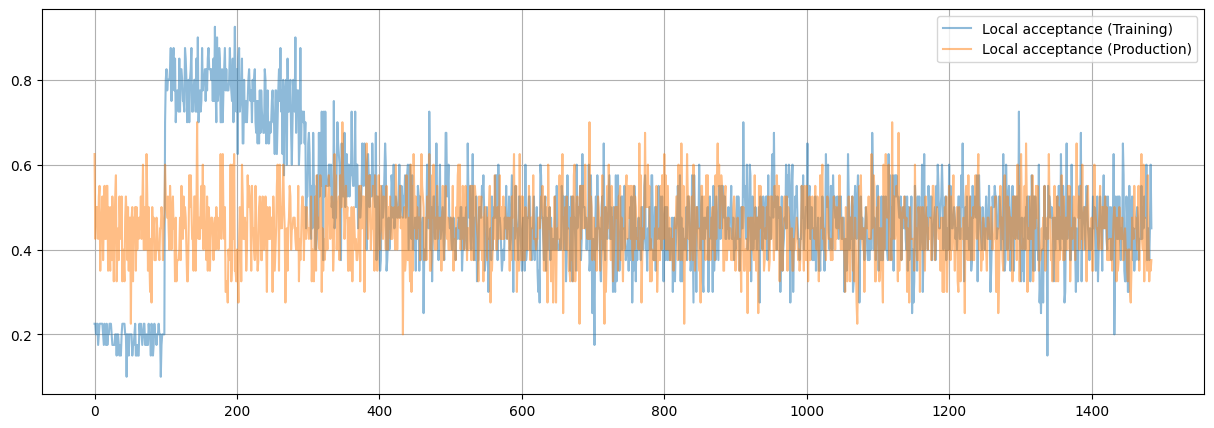

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(local_acceptance[:, 0], label="Local acceptance (Training)", alpha=0.5)
plt.plot(local_acceptance[:, 1], label="Local acceptance (Production)", alpha=0.5)
plt.legend()
plt.grid()

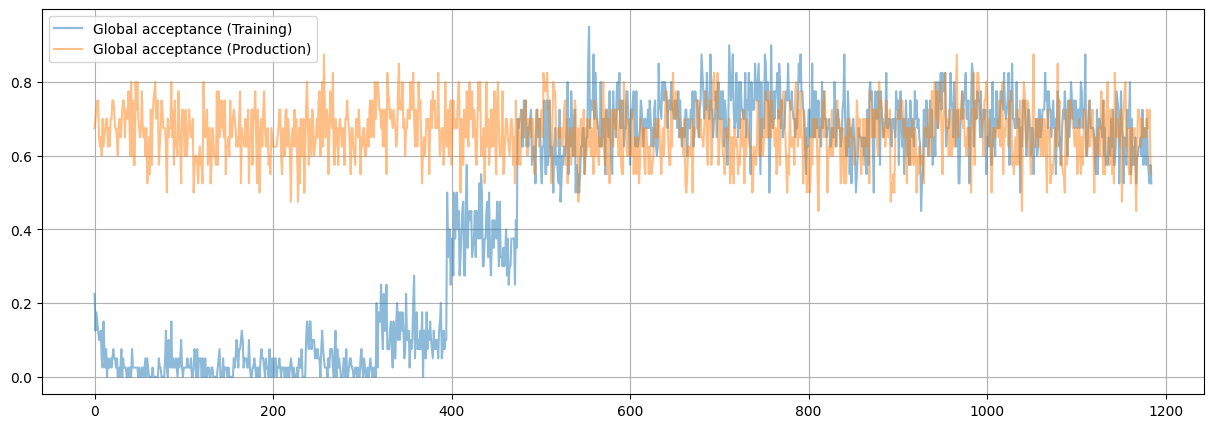

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(global_acceptance[:, 0], label="Global acceptance (Training)", alpha=0.5)
plt.plot(global_acceptance[:, 1], label="Global acceptance (Production)", alpha=0.5)
plt.legend()
plt.grid()

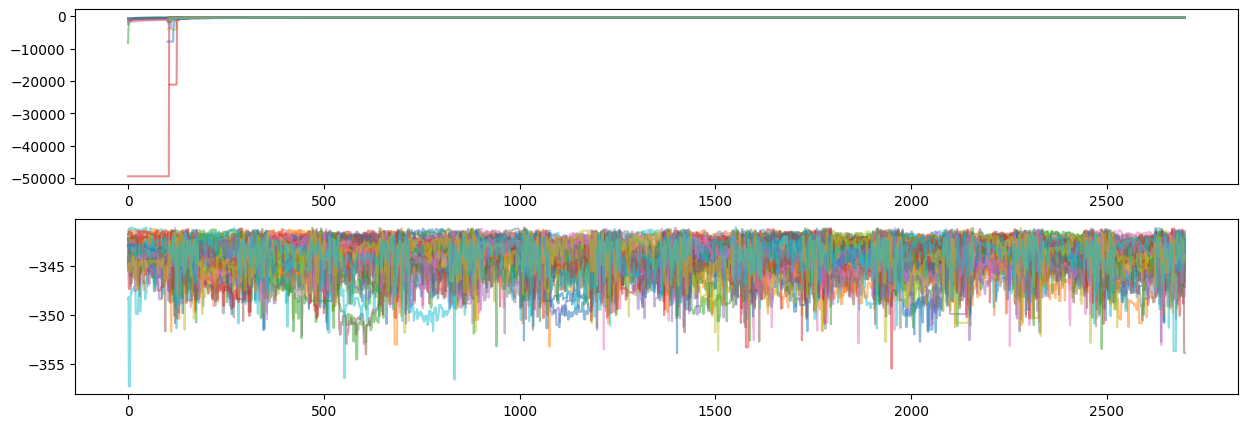

In [26]:
plt.figure(figsize=(15, 5))

log_prob = [
    np.loadtxt(f"sampler_data/log_prob_{i}.dat", skiprows=1) for i in range(n_chains)
]

plt.subplot(2, 1, 1)
for i in range(n_chains):
    plt.plot(log_prob[i][:, 0], alpha=0.5)

plt.subplot(2, 1, 2)
for i in range(n_chains):
    plt.plot(log_prob[i][:, 1], alpha=0.5)

Text(0.5, 0.98, 'Training chains')

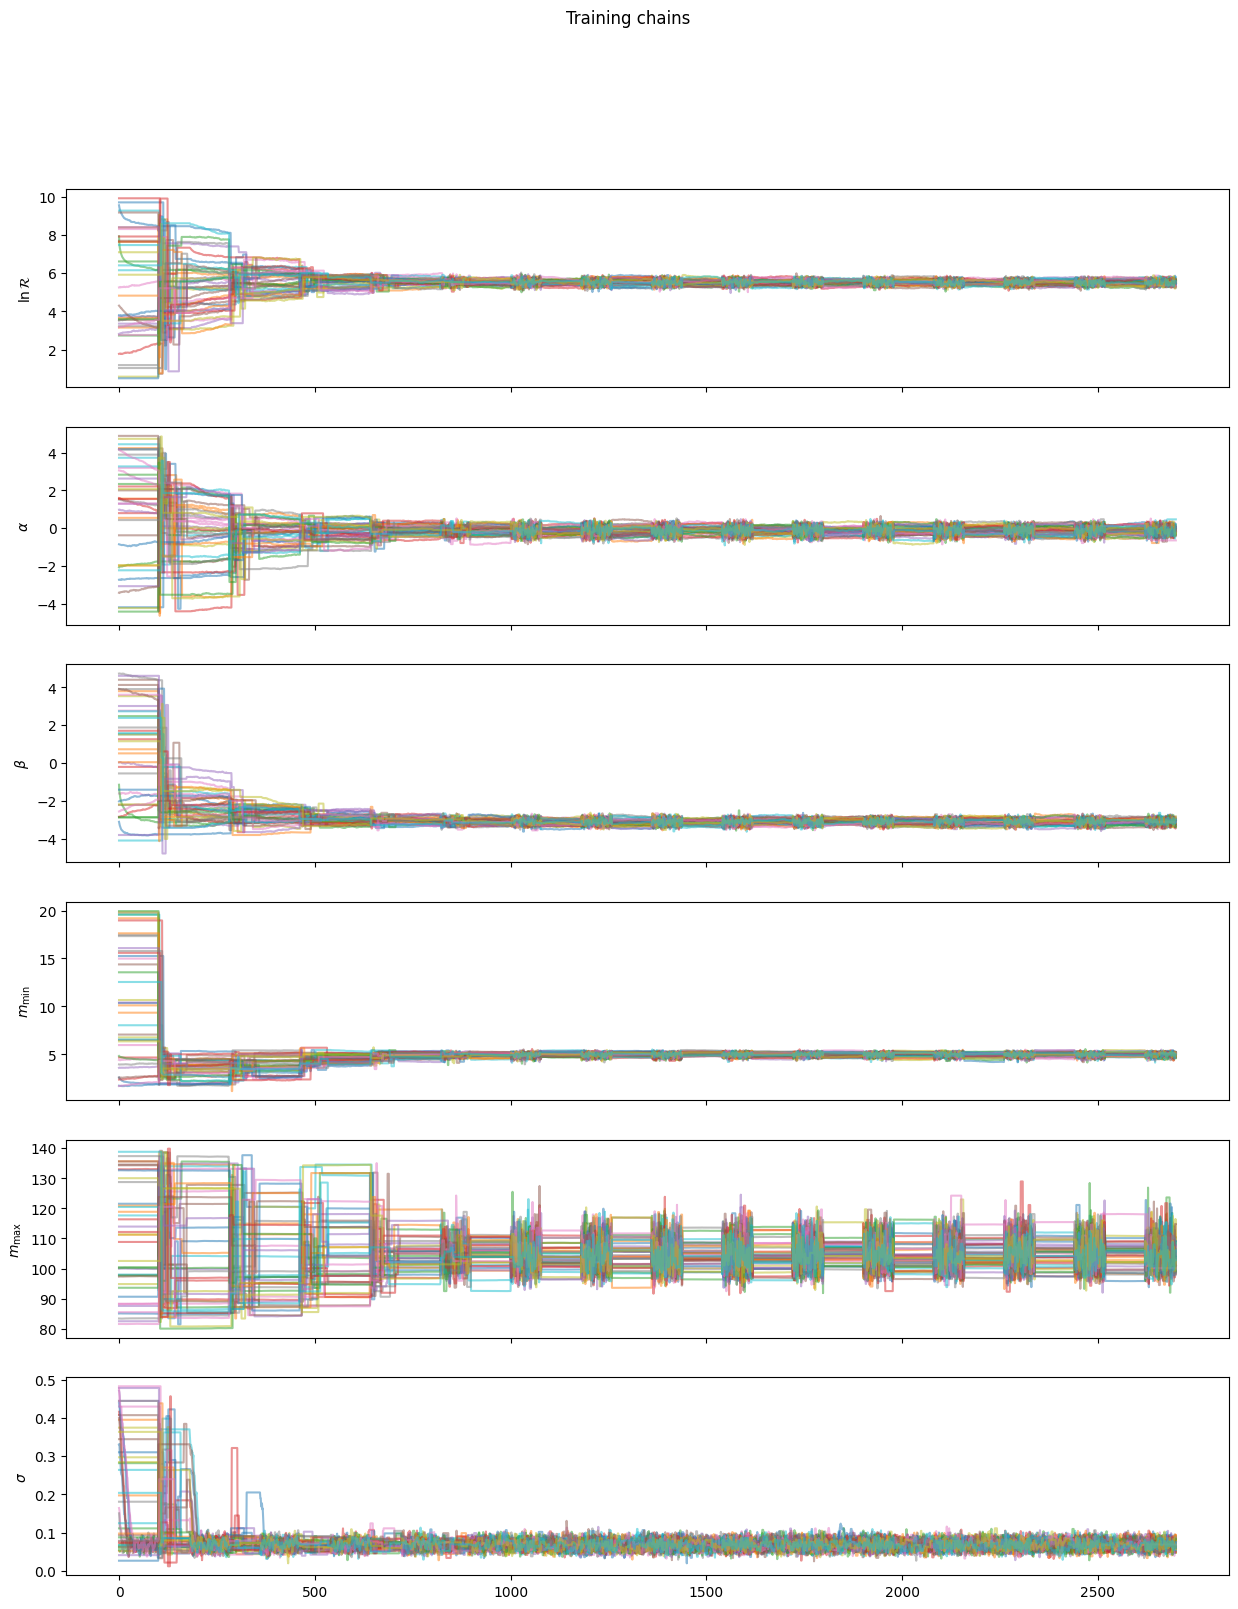

In [27]:
train_chains = [
    np.loadtxt(f"sampler_data/train_chains_{i}.dat", skiprows=1)
    for i in range(n_chains)
]

fig, ax = plt.subplots(n_dim, 1, figsize=(15, 3 * n_dim), sharex=True)
for j in range(n_dim):
    for i in range(n_chains):
        ax[j].plot(train_chains[i][:, j], alpha=0.5)
    ax[j].set_ylabel(titles[j])
plt.suptitle("Training chains")

Text(0.5, 0.98, 'Training chains')

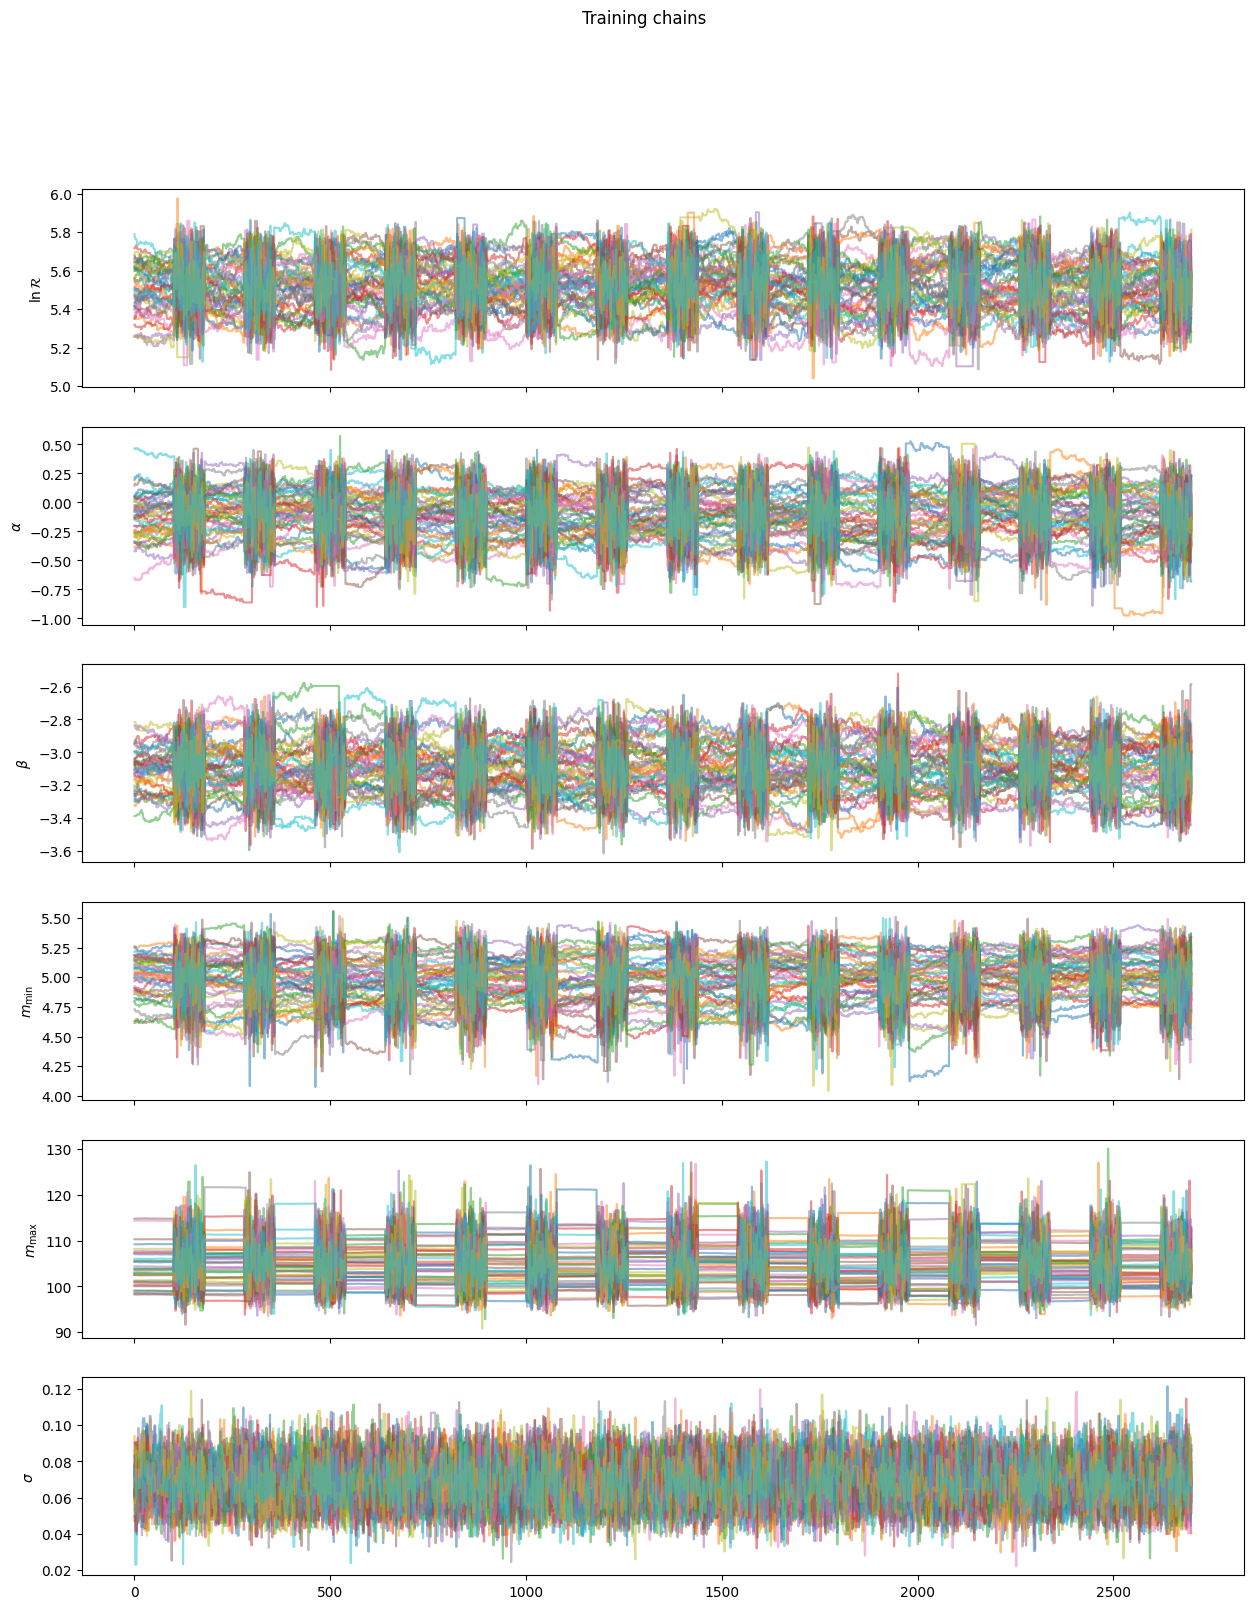

In [28]:
prod_chains = [
    np.loadtxt(f"sampler_data/prod_chains_{i}.dat", skiprows=1) for i in range(n_chains)
]

fig, ax = plt.subplots(n_dim, 1, figsize=(15, 3 * n_dim), sharex=True)
for j in range(n_dim):
    for i in range(n_chains):
        ax[j].plot(prod_chains[i][:, j], alpha=0.5)
    ax[j].set_ylabel(titles[j])
plt.suptitle("Training chains")

In [29]:
def r_hat(chains: np.ndarray, title: str) -> None:
    idata = az.convert_to_inference_data(chains)
    coords = {}
    data = get_coords(az.convert_to_dataset(idata, group="posterior"), coords)
    var_names = None
    filter_vars = None
    var_names = _var_names(var_names, data, filter_vars)
    n_draws = data.sizes["draw"]

    first_draw = data.draw.values[0]  # int of where where things should start

    ## Compute where to split the data to diagnostic the convergence
    n_split = 10
    draw_divisions = np.linspace(n_draws // n_split, n_draws, n_split, dtype=int)

    rhat_s = np.stack(
        [
            np.array(
                az.rhat(
                    data.sel(draw=slice(first_draw + draw_div)),
                    var_names=var_names,
                    method="rank",
                )["x"]
            )
            for draw_div in draw_divisions
        ]
    )
    labels = titles

    plt.plot(draw_divisions, rhat_s, "-o", label=labels)
    plt.axhline(1, c="k", ls="--")
    plt.xlabel("Iteration")
    plt.ylabel(r"$\hat{R}$")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
    plt.yscale("log")
    plt.title(title)
    plt.tight_layout()

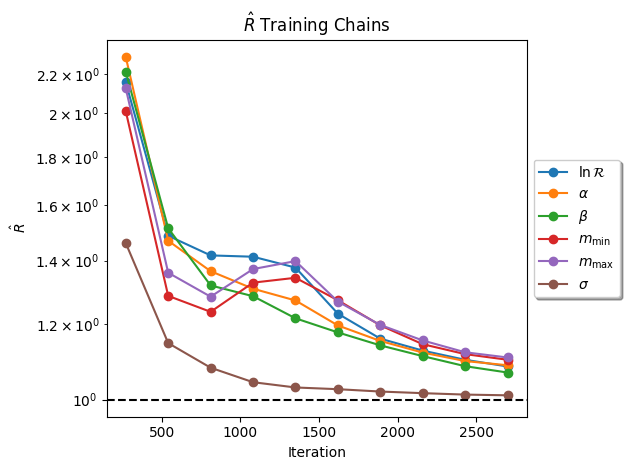

In [30]:
r_hat(np.array(train_chains), r"$\hat{R}$ Training Chains")

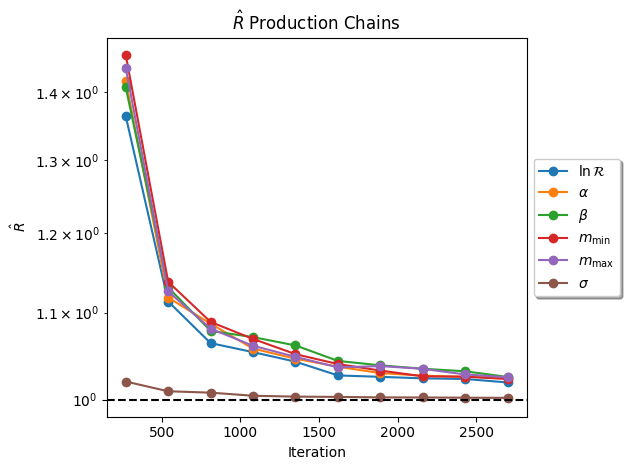

In [31]:
r_hat(np.array(prod_chains), r"$\hat{R}$ Production Chains")

In [32]:
nf_samples = np.loadtxt("sampler_data/nf_samples_unweighted.dat", skiprows=1)

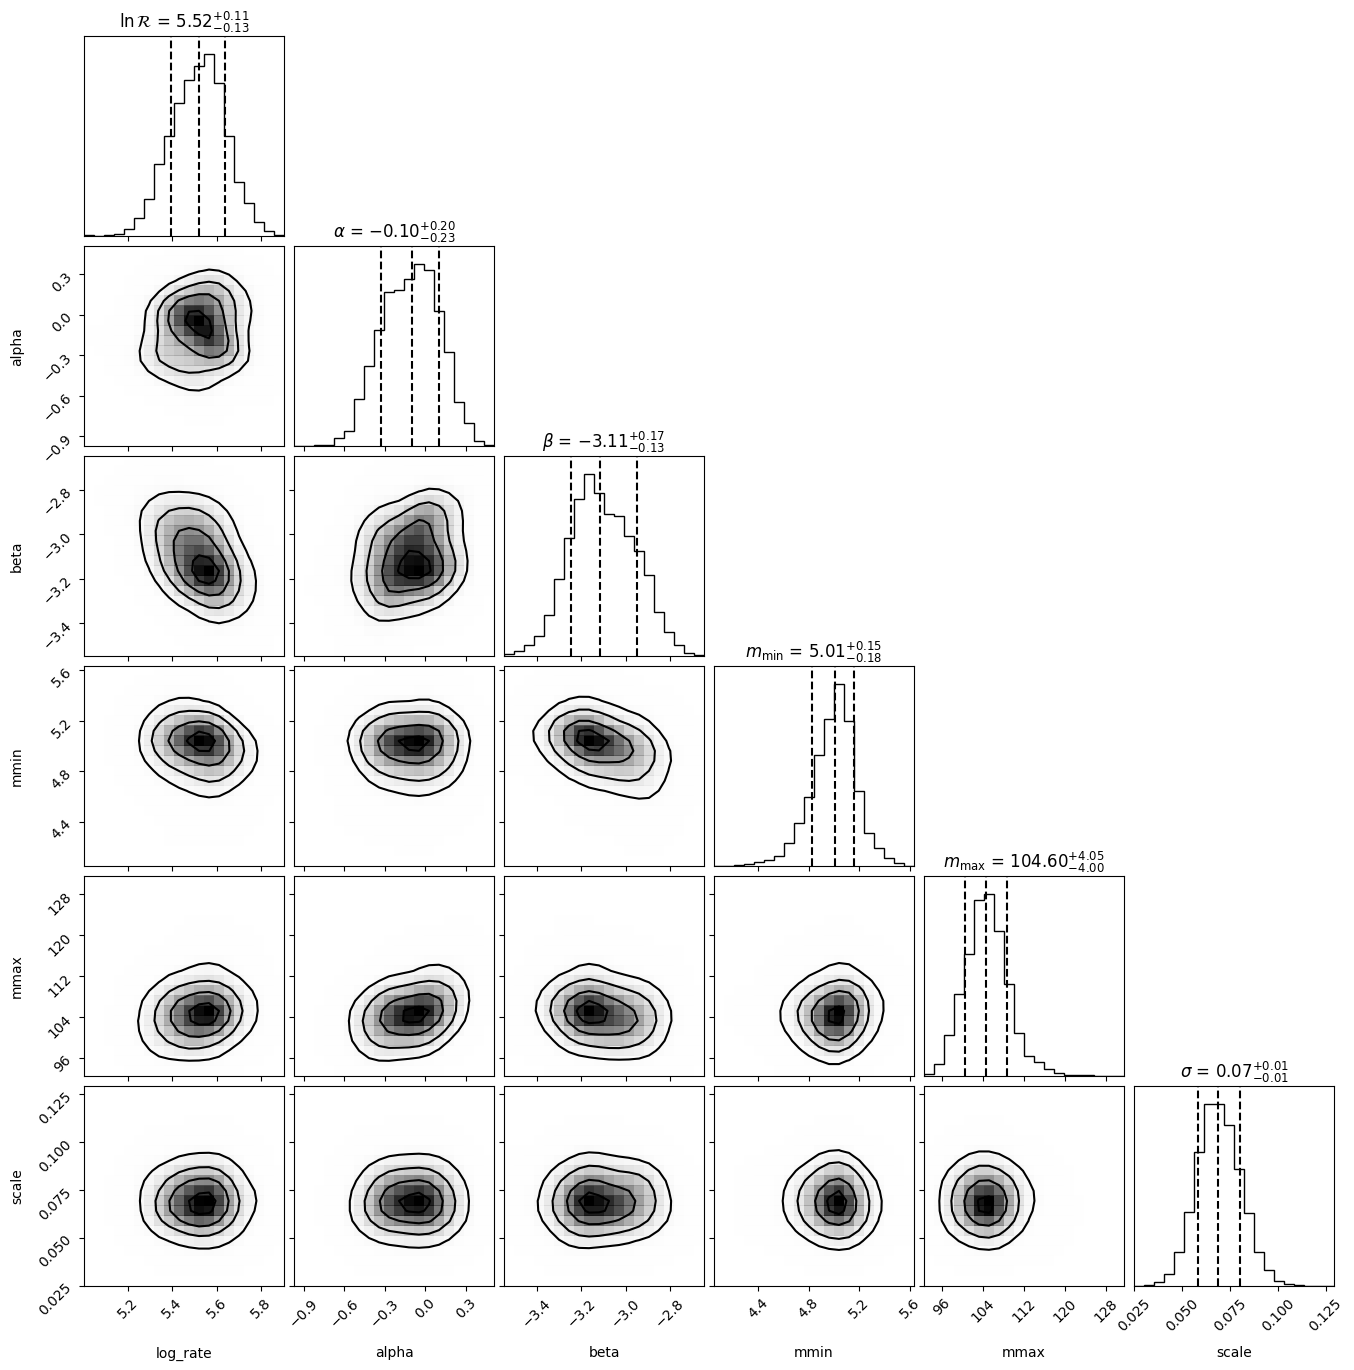

In [33]:
corner.corner(
    nf_samples,
    labels=data_dump_kwargs["labels"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    titles=titles,
    title_kwargs={"fontsize": 12},
    plot_datapoints=False,
    smooth=True,
)
plt.show()